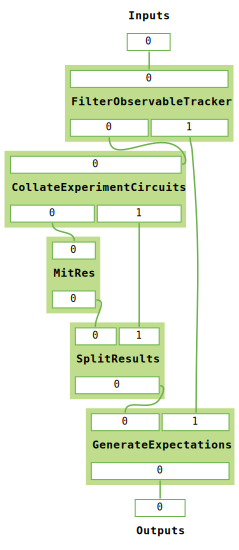

In [1]:
from qermit.taskgraph.mitex import MitEx, gen_compiled_MitRes
from pytket.extensions.qiskit import IBMQEmulatorBackend, AerBackend

noisy_backend = IBMQEmulatorBackend(
    backend_name='ibmq_jakarta', 
    hub='partner-cqc', 
    group='internal', 
    project='default')
# noisy_backend = AerBackend()
noisy_mitres = gen_compiled_MitRes(noisy_backend, optimisation_level=0)
noisy_mitex = MitEx(noisy_backend, mitres=noisy_mitres)
noisy_mitex.get_task_graph()

In [2]:
from qermit.taskgraph.mittask import MitTask
import numpy as np

def gen_param_grid_gen_task(n_vals):
    
    def task(obj, obs_exp_list):
        
        # A parameter grid is generated for each ObservableExperiment in obs_exp_list
        param_grid_list = []
        for obs_exp in obs_exp_list:
                        
            # List of symbols used in circuit
            sym_list = obs_exp.AnsatzCircuit.SymbolsDict.symbols_list
            
            # Lists of values taken by parameters, in half rotations
            param_val_list = [np.linspace(0, 2, n_vals, endpoint=False) for _ in sym_list]
            
            # Grids corresponding to paramert values
            param_grid = np.meshgrid(*param_val_list)
            param_grid_list.append(param_grid)
                    
        return (obs_exp_list, param_grid_list,)
    
    return MitTask(_label="ParamGridGen", _n_out_wires=2, _n_in_wires=1, _method=task)

In [3]:
import copy
from itertools import product

def empty_array(n_vals, dim):
    
    empty = None
    for _ in range(dim):
        empty = [empty] * n_vals
        
    return np.array(empty)

def gen_obs_exp_grid_gen_task(n_vals):
    
    def task(obj, obs_exp_list, param_grid_list):
        
        # A grid of ObservableExperiment is generated for each ObservableExperiment in obs_exp_list
        obs_exp_grid_list = []
        for obs_exp, param_grid in zip(obs_exp_list, param_grid_list):
                      
            # List of symbols in circuit
            sym_list = list(obs_exp.AnsatzCircuit.SymbolsDict.symbols_list)
            # TODO: Remove n_vals as an input here. It should be recoverable from param_grid
            obs_exp_grid = empty_array(n_vals, len(sym_list))
            shots = obs_exp.AnsatzCircuit.Shots
                        
            # Generate an ObservableExperiment for every parameter value in the grid
            for grid_point in product([i for i in range(n_vals)],repeat=len(sym_list)):
                                                
                sym_map = {sym:param[grid_point] for param, sym in zip(param_grid, sym_list)}  
                sym_dict = SymbolsDict().symbols_from_dict(sym_map)
                
                circ = obs_exp.AnsatzCircuit.Circuit.copy()
                
                anz_circ = AnsatzCircuit(circ, shots, sym_dict)
                obs = copy.deepcopy(obs_exp.ObservableTracker) # This needs to be a deep copy, which is a little scary
                
                obs_exp_grid[grid_point] = ObservableExperiment(anz_circ, obs)
                                
            obs_exp_grid_list.append(obs_exp_grid)
        
        return (obs_exp_grid_list, obs_exp_list, param_grid_list, )
    
    return MitTask(_label="ObsExpGridGen", _n_out_wires=3, _n_in_wires=2, _method=task)


In [4]:
from pytket.utils import QubitPauliOperator

def gen_flatten_task(n_vals):
    
    def task(obj, obs_exp_grid_list, obs_exp_list):
        
        # ObservableExperiments, currently stored in a grid, are flattned to a single list.
        # TODO: Is there a way of going this with the array flatten function
        flattened_obs_exp_list = []
        # Store strcuture of flattned grid as list of dictionaries.
        struct_list = []
                
        for i, (obs_exp, obs_exp_grid) in enumerate(zip(obs_exp_list, obs_exp_grid_list)):
            
            sym_list = list(obs_exp.AnsatzCircuit.SymbolsDict.symbols_list)
                        
            # Iterate through each grid point, and add ObservableExperiment to list
            for grid_point in product([i for i in range(n_vals)],repeat=len(sym_list)):
                flattened_obs_exp_list.append(obs_exp_grid[grid_point])
                struct_list.append({"experiment":i, "grid point":grid_point})
                                            
        return (flattened_obs_exp_list, struct_list, obs_exp_list, )
    
    return MitTask(_label="Flatten", _n_out_wires=3, _n_in_wires=2, _method=task)

def gen_unflatten_task(n_vals):
    
    def task(obj, result_list, struct_list, obs_exp_list) -> Tuple[List[QubitPauliOperator]]:
        
        result_grid_list = []
        
        # For each ObservableExperiment, create appropriatly sizes result grid
        for obs_exp in obs_exp_list:
            sym_list = list(obs_exp.AnsatzCircuit.SymbolsDict.symbols_list)
            result_grid_list.append(empty_array(n_vals, len(sym_list)))
        
        # For all results, add to the appropriate grid and grid point
        for result, struct in zip(result_list, struct_list):
            result_grid_list[struct["experiment"]][struct["grid point"]] = result
                
        return (result_grid_list, obs_exp_list, )
    
    return MitTask(_label="Unflatten", _n_out_wires=2, _n_in_wires=3, _method=task)

In [5]:
import matplotlib.pyplot as plt

def my_plot(z, *axis):
    
    if len(axis)==2:
        plot_3d(*axis, z)
    elif len(axis)==1:
        plot_2d(*axis, z)

def plot_3d(x,y,z):
    
    fig = plt.figure()
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(x,y, np.real(z))
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_surface(x,y, np.imag(z))
    
    plt.show()
    
def plot_2d(x,y):
    
    fig = plt.figure()
    
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(x, np.real(y))
    ax = fig.add_subplot(1, 2, 2)
    ax.scatter(x, np.imag(y))
    
    plt.show()

In [6]:
from numpy.fft import fftn, fftfreq, ifftn

def gen_fft_task(n_vals):
    
    def task(obj, result_grid_list, obs_exp_list, param_grid_list):
        
        fft_result_grid_list = []
        
        for qpo_result_grid, obs_exp, param_grid in zip(result_grid_list, obs_exp_list, param_grid_list):
                        
            sym_list = list(obs_exp.AnsatzCircuit.SymbolsDict.symbols_list)
            
            # for each point in qpo_result_grid, extract expectation value
            result_grid = empty_array(n_vals, len(sym_list))                  
            for grid_point in product([i for i in range(n_vals)],repeat=len(sym_list)):
                qpo_result_dict = qpo_result_grid[grid_point]._dict
                result = qpo_result_dict[list(qpo_result_dict.keys())[0]]
                result_grid[grid_point] = result
                                      
            # Perform FFT on grid of results.
            fft_result_grid = np.fft.fftn(result_grid) 
            fft_result_grid_list.append(fft_result_grid)
                        
            my_plot(result_grid, *param_grid)
            my_plot(fft_result_grid, *param_grid)
            
        return (fft_result_grid_list, param_grid_list, obs_exp_list, )
    
    return MitTask(_label="FFT", _n_out_wires=3, _n_in_wires=3, _method=task)

In [7]:
def gen_mitigation_task(tol):
    
    # TODO: Note that obs_exp_list is not used here
    def task(obj, fft_result_val_grid_list, param_grid_list, obs_exp_list):
        
        # Iterate through results grids and set values close to 0 to 0
        mitigated_fft_result_val_grid_list = []
        for fft_result_val_grid, param_grid in zip(fft_result_val_grid_list, param_grid_list):
            
            fft_result_val_grid[np.abs(fft_result_val_grid) < tol] = 0.0
            mitigated_fft_result_val_grid_list.append(fft_result_val_grid)
            
            my_plot(fft_result_val_grid, *param_grid)
        
        return (mitigated_fft_result_val_grid_list, param_grid_list, obs_exp_list)
    
    return MitTask(_label="Mitigation", _n_out_wires=3, _n_in_wires=3, _method=task)

In [8]:
def gen_inv_fft_task():
    
    # TODO: Note that obs_exp_list is not used here
    def task(obj, mitigated_fft_result_val_grid_list, param_grid_list, obs_exp_list):
        
        # Iterate through results and invert FFT
        mitigated_result_val_grid_list = []
        for mitigated_fft_result_val_grid, param_grid in zip(mitigated_fft_result_val_grid_list, param_grid_list):
                        
            mitigated_result_val_grid = np.fft.ifftn(mitigated_fft_result_val_grid)
            mitigated_result_val_grid_list.append(mitigated_result_val_grid)
                
            my_plot(mitigated_result_val_grid, *param_grid)
            
        return (mitigated_result_val_grid_list, )
    
    return MitTask(_label="InvFFT", _n_out_wires=1, _n_in_wires=3, _method=task)

In [9]:
def gen_result_extraction_task():
    
    def task(obj, results) -> Tuple[List[QubitPauliOperator]]:
        return (results, )
    
    return MitTask(_label="ResultExtraction", _n_out_wires=1, _n_in_wires=1, _method=task)

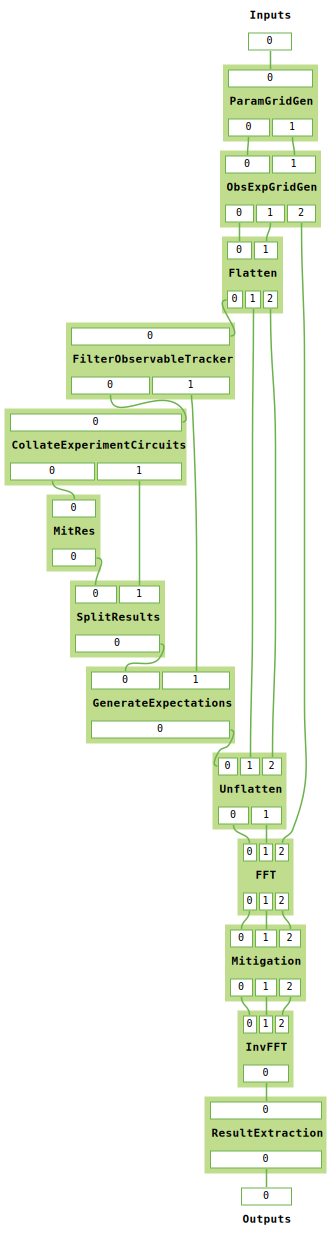

In [10]:
from qermit.taskgraph.task_graph import TaskGraph
from typing import Tuple, List
from qermit.taskgraph.mittask import (
    MitTask,
    CircuitShots,
    Wire,
)

n_vals=8

experiment_taskgraph = TaskGraph().from_TaskGraph(noisy_mitex)
experiment_taskgraph.add_wire()
experiment_taskgraph.add_wire()
experiment_taskgraph.prepend(gen_flatten_task(n_vals=n_vals))
experiment_taskgraph.append(gen_unflatten_task(n_vals=n_vals))

experiment_taskgraph.add_wire()
experiment_taskgraph.prepend(gen_obs_exp_grid_gen_task(n_vals=n_vals))

experiment_taskgraph.prepend(gen_param_grid_gen_task(n_vals=n_vals))

experiment_taskgraph.append(gen_fft_task(n_vals=n_vals))

experiment_taskgraph.append(gen_mitigation_task(tol=5))

experiment_taskgraph.append(gen_inv_fft_task())
experiment_taskgraph.append(gen_result_extraction_task())

experiment_taskgraph = MitEx(noisy_mitex).from_TaskGraph(experiment_taskgraph)
experiment_taskgraph.get_task_graph()

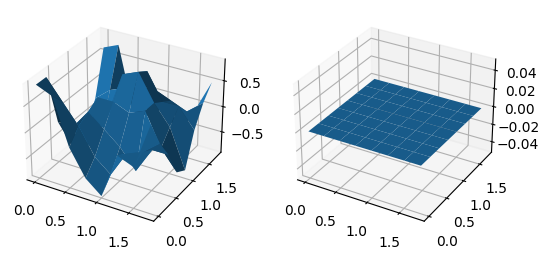

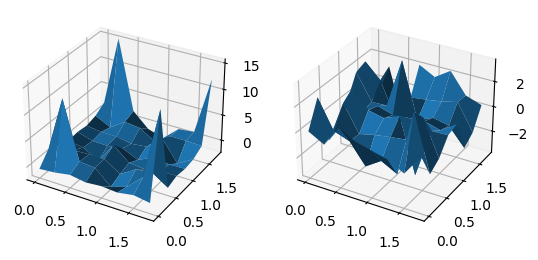

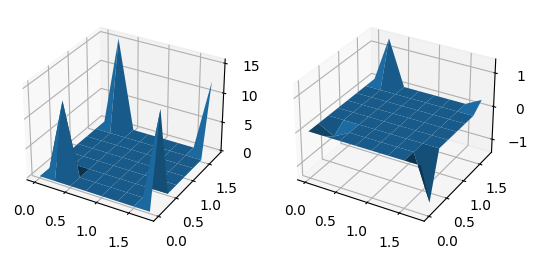

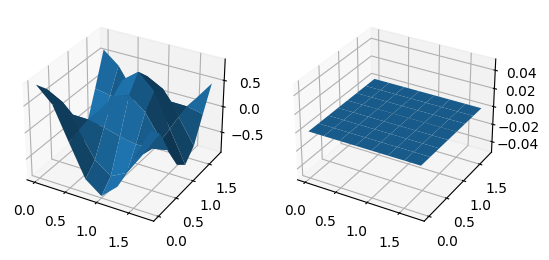

[array([[ 0.86353913+0.j,  0.58631037+0.j, -0.03437105+0.j,
         -0.63491838+0.j, -0.86353913+0.j, -0.58631037+0.j,
          0.03437105+0.j,  0.63491838+0.j],
        [ 0.64596692+0.j,  0.4884915 +0.j,  0.04486438+0.j,
         -0.42504368+0.j, -0.64596692+0.j, -0.4884915 +0.j,
         -0.04486438+0.j,  0.42504368+0.j],
        [ 0.04999605+0.j,  0.10452093+0.j,  0.09781887+0.j,
          0.03381584+0.j, -0.04999605+0.j, -0.10452093+0.j,
         -0.09781887+0.j, -0.03381584+0.j],
        [-0.57526183+0.j, -0.34067658+0.j,  0.09347239+0.j,
          0.4728665 +0.j,  0.57526183+0.j,  0.34067658+0.j,
         -0.09347239+0.j, -0.4728665 +0.j],
        [-0.86353913+0.j, -0.58631037+0.j,  0.03437105+0.j,
          0.63491838+0.j,  0.86353913+0.j,  0.58631037+0.j,
         -0.03437105+0.j, -0.63491838+0.j],
        [-0.64596692+0.j, -0.4884915 +0.j, -0.04486438+0.j,
          0.42504368+0.j,  0.64596692+0.j,  0.4884915 +0.j,
          0.04486438+0.j, -0.42504368+0.j],
        [-0.0499

In [13]:
from pytket import Circuit, Qubit
from pytket.pauli import QubitPauliString, Pauli
from qermit import AnsatzCircuit, SymbolsDict, ObservableExperiment, ObservableTracker
from sympy import Symbol
from pytket.circuit.display import render_circuit_jupyter

a = Symbol("alpha")
b = Symbol("beta")

circ = Circuit(2)
circ.H(0).H(1).Rz(a, 0).Rz(b, 1).H(0).H(1)
render_circuit_jupyter(circ)

sym_dict = SymbolsDict().symbols_from_dict({a:0.3, b:1.25})

qubit_pauli_string = QubitPauliString(
    [Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z]
)
ansatz_circuit = AnsatzCircuit(circ, 16, sym_dict)

exp = ObservableExperiment(
        ansatz_circuit,
        ObservableTracker(QubitPauliOperator({qubit_pauli_string: 1.0})),
    )

exp_list = [exp]

experiment_taskgraph.run(exp_list)